#**Project: Predicting stock market index using LSTM**

**Authors**: Hum Nath Bhandari, Binod Rimal, Nawa Raj Pokhrel, Ramchandra Rimal, Keshav Dahal, and Rajendra K.C. Khatri


# **Part I:  Data Creation and Exploration**

In this module we use various financial resources to create input data for our machine learning models. This includes the following data.
- S\&P 500 index data: Open price and Close price
- Vix index
- Interest Rate 
- Unemployment Rate
- Consumer sentiment index
- Dollar Index
- MACD
- RSI
- ATR

Our data will be the time series data with the following start and end date.

- start date: 2006/01/02
- end date:  2021/10/01


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
output_dir_path = r"c:\Users\Dimas\OneDrive - Institut Teknologi Bandung\Documents\Kuliah\TA Yok Bisa\coderef"


### **Importing basic libraries and APIs** 

In [2]:

import pandas as pd  ##import necessary libraries
import numpy as np
import math
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')


# import tensorflow as tf
# %load_ext tensorboard

import warnings
warnings.filterwarnings('ignore')

import os
import datetime as dt

## **Loading input data**

---



In [3]:
# data = pd.read_csv('/content/drive/My Drive/input_data.csv')
# data['Date']=pd.to_datetime(data['Date']).dt.date
# data.set_index("Date",inplace=True)
# data.head()

df = pd.read_excel("dataset-TA.xlsx")
df.set_index('Tanggal',inplace = True)
data = df.copy()
dates = df.index
dates = pd.to_datetime(dates)

In [4]:
data.tail()

,Terakhir,Pembukaan,Close IDR,Consumer Confidence,Emas USD,BI Rate
Tanggal,,,,,,
2022-12-26,1155.56,1148.94,15565.900391,113.1,1809.7,5.5
2022-12-27,1150.40,1155.67,15607.000000,113.1,1823.1,5.5
2022-12-28,1146.11,1150.40,15617.500000,113.1,1815.8,5.5
2022-12-29,1146.98,1146.22,15789.000000,113.1,1826.0,5.5
2022-12-30,1150.98,1147.04,15620.000000,113.1,1826.2,5.5


In [5]:
import matplotlib.dates as mdates

### **Data Exploration**

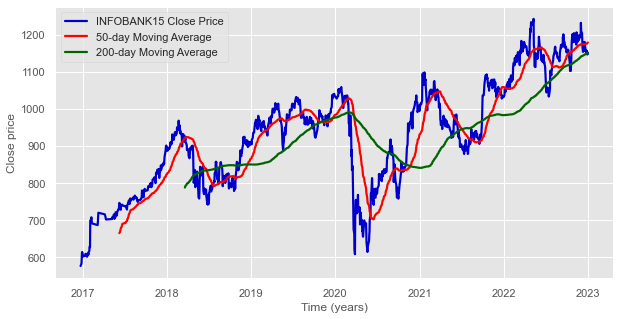

In [7]:
# df = data.copy()
df['MA_50'] = df['Terakhir'].rolling(50).mean()
df['MA_200'] = df['Terakhir'].rolling(200).mean()

fig = plt.figure(figsize=(10,5))
fig.set(facecolor = "white")
plt.plot(dates, df['Terakhir'],'mediumblue',label=['S&P 500 Close Price'], linewidth = 2.2)
plt.plot(dates, df['MA_50'],'red', label=['50-day MA'], linewidth = 2.2)
plt.plot(dates, df['MA_200'],'darkgreen', label=['200-day MA'], linewidth = 2.2)
plt.legend(['INFOBANK15 Close Price', '50-day Moving Average', '200-day Moving Average'], loc='upper left')
# Format the x-axis tick labels to show only the years
date_format = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis_date()
plt.title('')
plt.xlabel('Time (years)')
plt.ylabel('Close price')
fig.savefig(output_dir_path+ "original_data_plus_moving_averages.png",dpi=600)
plt.show()

####  **Correlation heatmap**

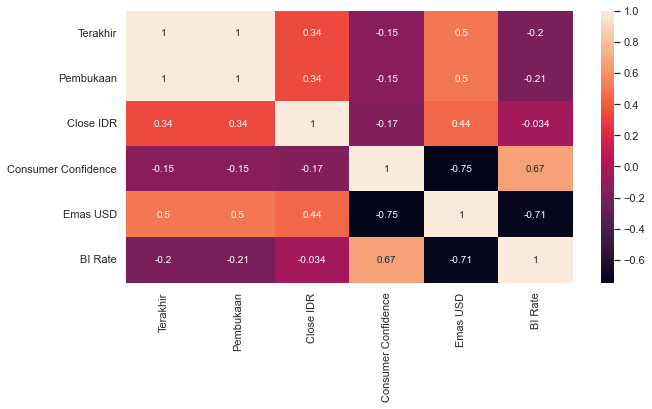

In [37]:

fig = plt.figure(figsize= (10,5))
sns.heatmap(data.corr(), annot=True)
sns.set_style("whitegrid")
#fig.savefig(output_dir_path+"correlation_heatmap.png",dpi=600)

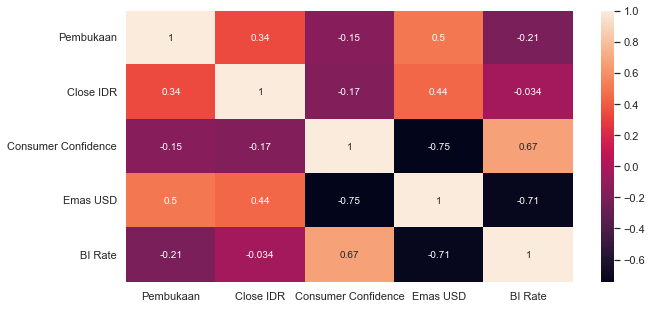

In [31]:
data = data.iloc[:, 1:]
fig = plt.figure(figsize= (10,5))
sns.heatmap(data.corr(), annot=True)
sns.set_style("whitegrid")
#fig.savefig(output_dir_path+"correlation_heatmap2.png",dpi=600)


<Figure size 1440x864 with 0 Axes>

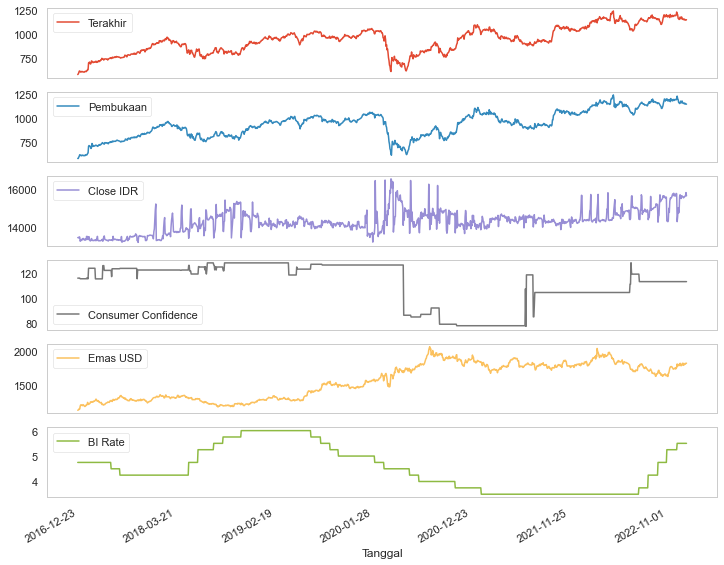

In [38]:
fig = plt.figure(figsize = (20, 12))
#fig.axes.get_yaxis().set_visible(False)
data.plot(subplots = True, figsize = (12,10),grid=False)
sns.set_style("whitegrid")
#fig.savefig(output_dir_path+"timeseries.png",dpi=600)
plt.show()

### **Denoising Closing Price**

In [11]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)

data['Close']= denoise_wavelet(data.iloc[:, 0], wavelet='haar',
                                      #method='BayesShrink', 
                                      method='VisuShrink',  
                                      mode='soft', rescale_sigma = True)
data.head()

,Pembukaan,Close IDR,Consumer Confidence,Emas USD,BI Rate,Close
Tanggal,,,,,,
2016-12-23,573.42,13449.0,115.9,1133.6,4.75,607.574338
2016-12-27,573.62,13442.0,115.9,1138.8,4.75,607.574338
2016-12-28,587.15,13429.0,115.9,1140.9,4.75,607.574338
2016-12-29,597.09,13490.0,115.9,1158.1,4.75,607.574338
2016-12-30,612.84,13466.0,115.9,1151.7,4.75,614.092713


In [39]:
data.drop("Pembukaan",axis=1,inplace=True)

### **Machine learning libraries**

In [6]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import time
import math


### **Supporting functions**

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return (np.mean(np.abs((y_true - y_pred)/(y_true))*100)) #some issues with zero denominator

def calculate_scores(y_true, y_pred):
  rmse = math.sqrt(mean_squared_error(y_true, y_pred))
  #R2_score = r2_score(y_true, y_pred)
  R = np.corrcoef(y_true, y_pred)
  #mae = mean_absolute_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  #dic = {'rmse':rmse, 'R2_score': R2_score, 'R':R[0,1], 'mae': mae, 'mape': mape}
  dic = {'rmse':rmse, 'R': R[0,1], 'mape': mape}
  return (dic)



def DatasetCreation(dataset, time_step = 1):  ##defining a function that gives a dataset and a time step, which then returns the input and output data
   DataX, DataY = [], []
   for i in range(len(dataset)- time_step -1):
         a = dataset[i:(i+ time_step), ]
         DataX.append(a)
         DataY.append(dataset[i + time_step, 0]) #ydata consists close price
   return np.array(DataX), np.array(DataY)


def data_split(data, split = 0.2):
  #======= creating training and test data===#
  l1   = int(len(data) * (1- split))
  l2    = len(data) - l1
  data1  = data.iloc[0:l1,:]
  data2   = data.iloc[l1:len(data),:]
  return data1, data2

def min_max_transform(data, feature_range=(0, 1)):
   scaler = MinMaxScaler(feature_range) 
   return scaler.fit_transform(data)

def min_max_inverse_transform(data_scaled, min_original, max_original):
    return min_original +  data_scaled*(max_original - min_original)



def write_dic_to_file(dic_name, file_name):
  file = open(file_name, 'w')
  file.write(str(dic_name))
  file.close()

import ast
def read_dic_from_file(file_name):
  file = open(file_name, "r")
  contents = file.read()
  dictionary = ast.literal_eval(contents)
  file.close()
  return dictionary



,Terakhir,Pembukaan,Close IDR,Consumer Confidence,Emas USD,BI Rate
Tanggal,,,,,,
2016-12-23,576.13,573.42,13449.000000,115.9,1133.6,4.75
2016-12-27,582.88,573.62,13442.000000,115.9,1138.8,4.75
2016-12-28,594.30,587.15,13429.000000,115.9,1140.9,4.75
2016-12-29,611.62,597.09,13490.000000,115.9,1158.1,4.75
2016-12-30,613.80,612.84,13466.000000,115.9,1151.7,4.75
...,...,...,...,...,...,...
2022-12-26,1155.56,1148.94,15565.900391,113.1,1809.7,5.50
2022-12-27,1150.40,1155.67,15607.000000,113.1,1823.1,5.50
2022-12-28,1146.11,1150.40,15617.500000,113.1,1815.8,5.50


## **Supporting functions for results visualization**

In [20]:
def test_scores_plot(model_output):
  neurons = model_output['avg_scores']['neurons']
  rmse = model_output['avg_scores']['rmse']
  #mae =  model_output['avg_scores']['mae']
  mape =  model_output['avg_scores']['mape']
  #R2 =   model_output['avg_scores']['R2']
  R =    model_output['avg_scores']['R']
  #time =  model_output['avg_scores']['elapsed_time']

  fig = plt.figure(figsize = (18, 4))
  plt.subplot(131)
  plt.plot(neurons, rmse, '--o', linewidth = 2, color = 'indigo')
  plt.title("(a)")
  plt.xlabel("Neurons")
  plt.ylabel("Avg. RMSE")
  sns.set_style("whitegrid")

  
  plt.subplot(132)
  plt.plot(neurons, mape, '--o', linewidth = 2, color = 'darkgreen')
  plt.title("(b)")
  plt.xlabel("Neurons")
  plt.ylabel("Avg. MAPE")


  plt.subplot(133)
  plt.plot(neurons, R, '--o', linewidth = 2, color = 'darkred')
  plt.title("(c)")
  plt.xlabel("Neurons")
  plt.ylabel("Avg. R ")

  fig.savefig(output_dir_path+"multiple_avg_scores_plots.png",dpi=600)
  plt.show()


def true_pred_plot(model_output):
  
  y_train = model_output['datasets']['y_train']
  y_test =  model_output['datasets']['y_test']

  train_pred = model_output['best_model']['train_predictions']
  test_pred = model_output['best_model']['test_predictions']

  ##====== Visualizing true vs predicted plots ========#
  fig = plt.figure(figsize= (14,5))
  plt.subplot(121)
  #sns.relplot(x = y_train_original, y = train_pred_original)
  plt.scatter(y_train, train_pred, marker= "+", color = 'mediumblue')
  identity_line = np.linspace(max(min(y_train), min(train_pred)), min(max(y_train), max(train_pred)))
  plt.plot(identity_line, identity_line, color="red", linestyle="dashed", linewidth= 2.5)

  plt.xlabel("True")
  plt.ylabel("Predicted")
  plt.title("(a)")

  plt.subplot(122)
  #sns.relplot(x = y_test_original, y = test_pred_original)
  plt.scatter(y_test, test_pred, marker = "+", color = 'mediumblue')
  identity_line = np.linspace(max(min(y_test), min(test_pred)), min(max(y_test), max(test_pred)))
  plt.plot(identity_line, identity_line, color="red", linestyle="dashed", linewidth= 2.5)
  plt.xlabel("True")
  plt.ylabel("Predicted")
  plt.title("(b)")
  fig.savefig(output_dir_path+"True_vs_predicted_plot.png", dpi=600)
  plt.show()


def prediction_plot(model_output):
  time_step =  model_output['hyper_parameters']['time_step']
  best_replicate = model_output['best_model']['replicate']

  data = model_output['datasets']['data']

  train_predict_plot_data = np.empty_like(data.values[:,0])# extracting closing price
  train_predict_plot_data[:] = np.nan

  test_predict_plot_data = np.empty_like(data.values[:,0])
  test_predict_plot_data[:] = np.nan

  fig1 = plt.figure(figsize = (18,12))

  plt.subplot(231)

  train_pred = model_output['train_predictions'][0][best_replicate]
  test_pred = model_output['test_predictions'][0][best_replicate]


  train_predict_plot_data[time_step:len(train_pred)+ time_step] =  train_pred
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] = test_pred
  
  plt.plot(dates,data.values[:,0],'k',linewidth = 1.5)
  plt.plot(train_predict_plot_data,'mediumblue',linewidth = 1.5)
  plt.plot(test_predict_plot_data,'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(a)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')

  plt.subplot(232)

  train_pred = model_output['train_predictions'][1][best_replicate]
  test_pred = model_output['test_predictions'][1][best_replicate]

  train_predict_plot_data[time_step:len(train_pred)+ time_step] =  train_pred 
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] =  test_pred

  plt.plot(dates,data.values[:,0],'k',linewidth = 1.5)
  plt.plot(train_predict_plot_data,'mediumblue',linewidth = 1.5)
  plt.plot(test_predict_plot_data,'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(b)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')

  plt.subplot(233)

  train_pred = model_output['train_predictions'][2][best_replicate]
  test_pred = model_output['test_predictions'][2][best_replicate]

  train_predict_plot_data[time_step:len(train_pred)+ time_step] = train_pred
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] =  test_pred

  plt.plot(dates,data.values[:,0],'k',linewidth = 1.5)
  plt.plot(train_predict_plot_data,'mediumblue',linewidth = 1.5)
  plt.plot(test_predict_plot_data,'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(c)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')


  plt.subplot(234)

  train_pred = model_output['train_predictions'][3][best_replicate]
  test_pred = model_output['test_predictions'][3][best_replicate]

  train_predict_plot_data[time_step:len(train_pred)+ time_step] = train_pred
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] = test_pred

  plt.plot(dates,data.values[:,0],'k',linewidth = 1.5)
  plt.plot(train_predict_plot_data,'mediumblue',linewidth = 1.5)
  plt.plot(test_predict_plot_data,'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(d)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')
  

  plt.subplot(235)

  train_pred = model_output['train_predictions'][4][best_replicate]
  test_pred = model_output['test_predictions'][4][best_replicate]

  train_predict_plot_data[time_step:len(train_pred)+ time_step] = train_pred
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] = test_pred

  plt.plot(dates,data.values[:,0],'k',linewidth = 1.5)
  plt.plot(train_predict_plot_data,'mediumblue',linewidth = 1.5)
  plt.plot(test_predict_plot_data,'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(e)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')

  plt.subplot(236)

  train_pred = model_output['train_predictions'][5][best_replicate]
  test_pred = model_output['test_predictions'][5][best_replicate]

  train_predict_plot_data[time_step:len(train_pred)+ time_step] = train_pred
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] = test_pred

  plt.plot(dates,data.values[:,0],'k',linewidth = 1.5)
  plt.plot(train_predict_plot_data,'mediumblue',linewidth = 1.5)
  plt.plot(test_predict_plot_data,'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(f)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')


  fig1.savefig(output_dir_path+"predictions_plots_fullset.png",dpi=600)
  plt.show()

  fig2 = plt.figure(figsize = (18,12))

  plt.subplot(231)
  plt.plot(dates,data.values[len(train_pred)+(time_step*2)+1:-1, 0],'mediumblue',linewidth = 1.5)
  plt.plot(model_output['test_predictions'][0][best_replicate], 'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(a)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')


  plt.subplot(232)

  plt.plot(dates,data.values[len(train_pred)+(time_step*2)+1:-1, 0],'mediumblue',linewidth = 1.5)
  plt.plot(model_output['test_predictions'][1][best_replicate], 'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(b)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')


  plt.subplot(233)

  plt.plot(dates,data.values[len(train_pred)+(time_step*2)+1:-1, 0],'mediumblue',linewidth = 1.5)
  plt.plot(model_output['test_predictions'][2][best_replicate], 'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(c)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')



  plt.subplot(234)

  plt.plot(dates,data.values[len(train_pred)+(time_step*2)+1:-1, 0],'mediumblue',linewidth = 1.5)
  plt.plot(model_output['test_predictions'][3][best_replicate], 'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(d)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')
  
  plt.subplot(235)

  plt.plot(dates,data.values[len(train_pred)+(time_step*2)+1:-1, 0],'mediumblue',linewidth = 1.5)
  plt.plot(model_output['test_predictions'][4][best_replicate], 'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(e)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')

  
  plt.subplot(236)

  plt.plot(dates,data.values[len(train_pred)+(time_step*2)+1:-1, 0],'mediumblue',linewidth = 1.5)
  plt.plot(model_output['test_predictions'][5][best_replicate], 'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(f)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')



  fig2.savefig(output_dir_path+"predictions_plots_testset.png",dpi=600)

  plt.show()

def best_model_prediction_plot(model_output):

  time_step =  model_output['hyper_parameters']['time_step']

  data = model_output['datasets']['data']

  train_predict_plot_data = np.empty_like(data.values[:,0])# extracting closing price
  train_predict_plot_data[:] = np.nan

  test_predict_plot_data = np.empty_like(data.values[:,0])
  test_predict_plot_data[:] = np.nan

  
  fig = plt.figure(figsize = (14,5))

  plt.subplot(121)

  train_pred = model_output['best_model']['train_predictions']
  test_pred = model_output['best_model']['test_predictions']

  train_predict_plot_data[time_step:len(train_pred)+ time_step] =  train_pred
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] = test_pred
  
  plt.plot(dates,data.values[:,0],'k', linewidth = 1.5)
  plt.plot(train_predict_plot_data,'mediumblue',linewidth = 1.5)
  plt.plot(test_predict_plot_data,'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(a)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')


  plt.subplot(122)
  plt.plot(dates,data.values[len(train_pred)+(time_step*2)+1:-1, 0],'k',linewidth = 1.5)
  plt.plot(test_pred,'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(b)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')

  fig.savefig(output_dir_path+"best_model_predictions_plots.png",dpi=600)


def rmse_boxplots(model_output):
  fig = plt.figure(figsize = (6,5))
  plt.boxplot(model_output['scores']['rmse'], patch_artist=True)
  plt.xticks([1,2,3,4,5,6], ['10', '30', '50', '100', '150', '200'])
  plt.xlabel('Number of neurons')
  plt.ylabel('RMSE')
  fig.savefig(output_dir_path+"rmse_boxplots.png",dpi=600)
  plt.show()


def rmse_violinplotplots(model_output):
  fig = plt.figure(figsize = (6,5))
  plt.violinplot(model_output['scores']['rmse'])
  plt.xticks([1,2,3,4,5,6], ['10', '30', '50', '100', '150', '200'])
  plt.xlabel('Number of neurons')
  plt.ylabel('RMSE')
  fig.savefig(output_dir_path+"rmse_violinplots.png",dpi=600)
  plt.show()

def all_scores_boxplots(model_output):

  fig = plt.figure(figsize = (18,5))
  plt.subplot(131)
  p1 = plt.boxplot(model_output['scores']['rmse'],patch_artist=True)
  for i, box in enumerate(p1['boxes']):
    # change outline color
    box.set(color= 'blue', linewidth = 1.2)
    # change fill color
    box.set(facecolor = 'mediumblue')
  plt.xticks([1,2,3,4,5,6], ['10', '30', '50', '100', '150', '200'])
  plt.title("(a)")
  plt.xlabel('Number of neurons')
  plt.ylabel('RMSE')

  plt.subplot(132)
  p2 = plt.boxplot(model_output['scores']['mape'],patch_artist=True)
  for i, box in enumerate(p2['boxes']):
    #change outline color
    box.set(color= 'blue', linewidth = 1.2)
    # change fill color
    box.set(facecolor = 'indigo')

  plt.xticks([1,2,3,4,5,6], ['10', '30', '50', '100', '150', '200'])
  plt.title("(b)")
  plt.xlabel('Number of neurons')
  plt.ylabel('MAPE')

  plt.subplot(133)
  p3 = plt.boxplot(model_output['scores']['R'],patch_artist=True)
  for i, box in enumerate(p3['boxes']):
    #change outline color
    box.set(color= 'blue', linewidth = 1.2)
    # change fill color
    box.set(facecolor = 'darkgreen')
  plt.xticks([1,2,3,4,5,6], ['10', '30', '50', '100', '150', '200'])
  plt.title("(c)")
  plt.xlabel('Number of neurons')
  plt.ylabel('R')

  fig.savefig(output_dir_path+"all_scores_boxplots.png",dpi=600)
  plt.show()


def create_visualization(model_output):
  true_pred_plot(model_output)
  test_scores_plot(model_output)
  prediction_plot(model_output)
  best_model_prediction_plot(model_output)
  rmse_boxplots(model_output)
  all_scores_boxplots(model_output)
  

  

## **Function for Building Models**

In [9]:
def build_model(layers, time_step, num_features, optimizer,learning_rate, verbose = 1):
  
  model = Sequential()
    
  for i in range(len(layers)):
    if len(layers)==1:
      model.add(LSTM(np.int(layers[i]), input_shape = (time_step, num_features)))
    else:
      if i < len(layers)-1:
        if i == 0:
          model.add(LSTM(np.int(layers[i]), input_shape=(time_step, num_features), return_sequences= True))
          #model.add(Dropout(0.10))
        else:
          model.add(LSTM(np.int(layers[i]), return_sequences=True))
          #model.add(Dropout(0.10))
      else:
        model.add(LSTM(np.int(layers[i])))
        #model.add(Dropout(0.10))  
  model.add(Dense(1, activation = 'linear'))
  
  if optimizer == 'Adam':
    opt = optimizers.Adam(lr = learning_rate)
  elif optimizer == 'Adagrad': 
    opt = optimizers.Adagrad(lr = learning_rate)
  elif optimizer == 'Nadam':
    opt = optimizers.Nadam(lr = learning_rate)
  elif optimizer == 'Adadelta':
    opt = optimizers.Adadelta(lr= learning_rate)
  elif optimizer == 'RMSprop':
    opt = optimizers.RMSprop(lr= learning_rate)
  else:
    print("No optimizer found in the list(['Adam', 'Adagrad','Nadam', 'Adadelta', 'RMSprop'])! Please apply your optimizer manually...")

  model.compile(loss='mean_squared_error', optimizer= opt)
   
  if verbose == 1:
    print(model.summary())
  return model

### Testing

In [10]:
optimizers_names = ['Adam', 'Adagrad', 'Nadam']

build_model([250], 5, 10, optimizers_names[2], 0.001, 1)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 250)               261000    
_________________________________________________________________
dense (Dense)                (None, 1)                 251       
Total params: 261,251
Trainable params: 261,251
Non-trainable params: 0
_________________________________________________________________
None


## **Function for Hyperparameter Tuning**

In [11]:
def hyper_parameter_tuning(layers, data, time_step, split, optimizers_names, learning_rates, batch_sizes, epochs, num_replicates = 2):
  #======= creating training and test data===#
  train_data, val_data = data_split(data, split)

  num_features = train_data.shape[1]

  min_train, max_train  = train_data["Terakhir"].min(), train_data["Terakhir"].max()
  min_val, max_val   =    val_data["Terakhir"].min(), val_data["Terakhir"].max()

  train_data_scaled  =  min_max_transform(train_data)
  val_data_scaled    = min_max_transform(val_data)

  X_train, y_train =   DatasetCreation(train_data_scaled, time_step)
  X_val, y_val     =   DatasetCreation(val_data_scaled, time_step)
   
  #========dealing with time series=========#
  
  best_avg_rmse = 99999999999
  
  collect_rmse = []
  
  all_avg_rmse = np.zeros((len(optimizers_names), len(learning_rates), len(batch_sizes)))

  best_hyper_parameters = {"model": layers, "optimizer": None, "learning_rate": None, "batch_size": None,"best_avg_rmse": None}
  
  for opt in range(len(optimizers_names)):
    
    for lr in range(len(learning_rates)):
      
      for batch_size in range(len(batch_sizes)):
        
        for i in range(num_replicates):

          print("Running for " + optimizers_names[opt] + " optimizer " + str(learning_rates[lr]) +  " learning_rate " +  str(batch_sizes[batch_size]) + " batch_size and " + str(i) +  " replicate " +  "\n")
                
          model = build_model(layers, time_step, num_features, optimizers_names[opt], learning_rate = learning_rates[lr], verbose = 0)
          
          callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 5,verbose = 1)

          # history = model.fit(X_train, y_train, batch_size = batch_sizes[batch_size], epochs= epochs, validation_data = (X_val, y_val), callbacks=[callback], verbose = 1)
          history = model.fit(X_train, y_train, batch_size = batch_sizes[batch_size], epochs= epochs, validation_data = (X_val, y_val), callbacks=[callback])
                  
          

          #==============Making predictions in original scale ==========
          
          val_pred    =  min_max_inverse_transform(model.predict(X_val).ravel(), min_val, max_val)

          collect_rmse.append(math.sqrt(mean_squared_error(min_max_inverse_transform(y_val, min_val, max_val),val_pred)))
                  
        avg_rmse = np.mean(np.array(collect_rmse))
        all_avg_rmse[opt][lr][batch_size] = avg_rmse

        if avg_rmse < best_avg_rmse:
          best_avg_rmse = avg_rmse
          best_hyper_parameters = {"model": layers,  "optimizer": optimizers_names[opt], "learning_rate": learning_rates[lr], "batch_size": batch_sizes[batch_size], "best_avg_rmse": best_avg_rmse} 


  output_dictionary = {
      "best_hyper_parameters":  best_hyper_parameters,
      "all_avg_rmse": all_avg_rmse
       } 

  #writing output dictionary in the file

  file_name = output_dir_path+ "sl-lstm-" + str(layers[0])+ "-neurons-validation_results"+ str(time.time())+ ".txt"
  write_dic_to_file(output_dictionary, file_name)

  print("Best_hyper_parameters: \n", output_dictionary['best_hyper_parameters']) 
  print("all_avg_rmse: \n", output_dictionary['all_avg_rmse'])

  return output_dictionary['best_hyper_parameters']



### **Case I: Tuning parameter of 10N-singlelayer-LSTM**

In [44]:

layers = [10]
time_step = 5
optimizers_names = ['Adam']
#optimizers_names = ['Adam']
learning_rates =  [0.1, 0.01, 0.001]
batch_sizes =  [4, 8, 16]
epochs = 50
num_replicates = 3
test_split = 0.2 
val_split = 0.2

train_data, test_data = data_split(data, test_split)

N10_best_hyper_parameters = hyper_parameter_tuning(layers, train_data, time_step, val_split, optimizers_names, learning_rates, batch_sizes, epochs = epochs, num_replicates = num_replicates)
N10_best_hyper_parameters


Running for Adam optimizer 0.1 learning_rate 4 batch_size and 0 replicate 

Train on 787 samples, validate on 193 samples
Epoch 1/50
787/787 [==============================] - 17s 22ms/sample - loss: 0.0278 - val_loss: 0.0068
Epoch 2/50
787/787 [==============================] - 2s 2ms/sample - loss: 0.0015 - val_loss: 0.0049
Epoch 3/50
787/787 [==============================] - 2s 3ms/sample - loss: 0.0016 - val_loss: 0.0040
Epoch 4/50
787/787 [==============================] - 2s 2ms/sample - loss: 0.0017 - val_loss: 0.0040
Epoch 5/50
787/787 [==============================] - 2s 3ms/sample - loss: 0.0017 - val_loss: 0.0049
Epoch 6/50
787/787 [==============================] - 2s 3ms/sample - loss: 0.0016 - val_loss: 0.0061
Epoch 7/50
787/787 [==============================] - 2s 3ms/sample - loss: 0.0018 - val_loss: 0.0054
Epoch 8/50
787/787 [==============================] - 2s 3ms/sample - loss: 0.0020 - val_loss: 0.0074
Epoch 9/50
787/787 [==============================] - 2s 3ms

{'model': [10],
 'optimizer': 'Adam',
 'learning_rate': 0.01,
 'batch_size': 16,
 'best_avg_rmse': 14.502820475707669}

### **Case II: Tuning parameter of 30N-singlelayer-LSTM**

In [45]:

layers = [30]
time_step = 5
optimizers_names = ['Adam']
learning_rates =  [0.1, 0.01, 0.001]
batch_sizes =  [4, 8, 16]
epochs =  50
num_replicates = 3
test_split = 0.2 
val_split = 0.2

train_data, test_data = data_split(data, test_split)

N30_best_hyper_parameters = hyper_parameter_tuning(layers, train_data, time_step, val_split, optimizers_names, learning_rates, batch_sizes, epochs = epochs, num_replicates = num_replicates)
N30_best_hyper_parameters


Running for Adam optimizer 0.1 learning_rate 4 batch_size and 0 replicate 

Train on 787 samples, validate on 193 samples
Epoch 1/50
787/787 [==============================] - 21s 27ms/sample - loss: 0.0767 - val_loss: 0.0034
Epoch 2/50
787/787 [==============================] - 2s 3ms/sample - loss: 0.0013 - val_loss: 0.0037
Epoch 3/50
787/787 [==============================] - 2s 3ms/sample - loss: 0.0016 - val_loss: 0.0054
Epoch 4/50
787/787 [==============================] - 2s 3ms/sample - loss: 0.0020 - val_loss: 0.0060
Epoch 5/50
787/787 [==============================] - 3s 3ms/sample - loss: 0.0016 - val_loss: 0.0039
Epoch 6/50
787/787 [==============================] - 3s 4ms/sample - loss: 0.0014 - val_loss: 0.0045
Epoch 00006: early stopping
Running for Adam optimizer 0.1 learning_rate 4 batch_size and 1 replicate 

Train on 787 samples, validate on 193 samples
Epoch 1/50
787/787 [==============================] - 20s 26ms/sample - loss: 0.0459 - val_loss: 0.0044
Epoch 2/50

{'model': [30],
 'optimizer': 'Adam',
 'learning_rate': 0.01,
 'batch_size': 16,
 'best_avg_rmse': 14.163673053416879}

### **Case III: Tuning parameter of 50N-singlelayer-LSTM**

---



In [46]:

layers = [50]
time_step = 5
optimizers_names = ['Adam']
learning_rates =  [0.1, 0.01, 0.001]
batch_sizes =  [4, 8, 16]
epochs = 50
num_replicates = 3
test_split = 0.2 
val_split = 0.2

train_data, test_data = data_split(data, test_split)

N50_best_hyper_parameters = hyper_parameter_tuning(layers, train_data, time_step, val_split, optimizers_names, learning_rates, batch_sizes, epochs = epochs, num_replicates = num_replicates)
N50_best_hyper_parameters


Running for Adam optimizer 0.1 learning_rate 4 batch_size and 0 replicate 

Train on 787 samples, validate on 193 samples
Epoch 1/50
787/787 [==============================] - 34s 43ms/sample - loss: 0.2471 - val_loss: 0.0120
Epoch 2/50
787/787 [==============================] - 4s 5ms/sample - loss: 0.0032 - val_loss: 0.0054 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.0
Epoch 3/50
787/787 [==============================] - 4s 5ms/sample - loss: 0.0032 - val_loss: 0.0083
Epoch 4/50
787/787 [==============================] - 4s 5ms/sample - loss: 0.0019 - val_loss: 0.0042.001
Epoch 5/50
787/787 [==============================] - 4s 5ms/sample - loss: 0.0023 - val_loss: 0.0044
Epoch 6/50
787/787 [==============================] - 4s 5ms/sample - loss: 0.0027 - val_loss: 0.0039
Epoch 7/50
787/787 [==============================] - 4s 5ms/sample - loss: 0.0016 - val_loss: 0.0063
Epoch 8/50
787/787 [==============================] - 4s 5ms/sample - loss: 0.0020 - val_loss: 0.0057
Epoch 9/50

{'model': [50],
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 8,
 'best_avg_rmse': 16.04985696460467}

### **Case IV: Tuning parameter of 100N-singlelayer-LSTM**

---

In [47]:

layers = [100]
time_step = 5
optimizers_names = ['Adam']
learning_rates =  [0.1, 0.01, 0.001]
batch_sizes =  [4, 8, 16]
epochs =  50
num_replicates = 3
test_split = 0.2 
val_split = 0.2

train_data, test_data = data_split(data, test_split)

N100_best_hyper_parameters = hyper_parameter_tuning(layers, train_data, time_step, val_split, optimizers_names, learning_rates, batch_sizes, epochs = epochs, num_replicates = num_replicates)
N100_best_hyper_parameters


Running for Adam optimizer 0.1 learning_rate 4 batch_size and 0 replicate 

Train on 787 samples, validate on 193 samples
Epoch 1/50
787/787 [==============================] - 62s 79ms/sample - loss: 1.0485 - val_loss: 0.0162
Epoch 2/50
787/787 [==============================] - 17s 22ms/sample - loss: 0.0053 - val_loss: 0.0063
Epoch 3/50
787/787 [==============================] - 17s 22ms/sample - loss: 0.0037 - val_loss: 0.0126
Epoch 4/50
787/787 [==============================] - 18s 23ms/sample - loss: 0.0042 - val_loss: 0.0050
Epoch 5/50
787/787 [==============================] - 17s 22ms/sample - loss: 0.0028 - val_loss: 0.0050
Epoch 6/50
787/787 [==============================] - 17s 22ms/sample - loss: 0.0029 - val_loss: 0.0039
Epoch 7/50
787/787 [==============================] - 17s 22ms/sample - loss: 0.0018 - val_loss: 0.0081
Epoch 8/50
787/787 [==============================] - 19s 24ms/sample - loss: 0.0044 - val_loss: 0.0038
Epoch 9/50
787/787 [==========================

{'model': [100],
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 16,
 'best_avg_rmse': 21.379305620149044}

### **Case V: Tuning parameter of 150N-singlelayer-LSTM**

In [41]:

layers = [150]
time_step = 5
optimizers_names = ['Adam']
learning_rates =  [0.1, 0.01, 0.001]
batch_sizes =  [4, 8, 16]
epochs =  50
num_replicates = 3
test_split = 0.2 
val_split = 0.2

train_data, test_data = data_split(data, test_split)

N150_best_hyper_parameters = hyper_parameter_tuning(layers, train_data, time_step, val_split, optimizers_names, learning_rates, batch_sizes, epochs = epochs, num_replicates = num_replicates)
N150_best_hyper_parameters


Running for Adam optimizer 0.1 learning_rate 4 batch_size and 0 replicate 



Train on 787 samples, validate on 193 samples
Epoch 1/50
787/787 [==============================] - 6s 7ms/sample - loss: 1.4098 - val_loss: 0.0080
Epoch 2/50
787/787 [==============================] - 3s 4ms/sample - loss: 0.0040 - val_loss: 0.0099
Epoch 3/50
787/787 [==============================] - 3s 4ms/sample - loss: 0.0052 - val_loss: 0.0039
Epoch 4/50
787/787 [==============================] - 4s 5ms/sample - loss: 0.0067 - val_loss: 0.0084
Epoch 5/50
787/787 [==============================] - 4s 5ms/sample - loss: 0.0035 - val_loss: 0.0045
Epoch 6/50
787/787 [==============================] - 3s 4ms/sample - loss: 0.0068 - val_loss: 0.0264
Epoch 7/50
787/787 [==============================] - 4s 4ms/sample - loss: 0.0061 - val_loss: 0.0055
Epoch 8/50
787/787 [==============================] - 4s 5ms/sample - loss: 0.0039 - val_loss: 0.0141
Epoch 00008: early stopping
Running for Adam optimizer 0.1 learning_rate 4 batch_size and 1 replicate 

Train on 787 samples, validate on 

{'model': [150],
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 16,
 'best_avg_rmse': 22.52703664401859}

### **Case VI: Tuning parameter of 200N-singlelayer-LSTM**

In [48]:

layers = [200]
time_step = 5
optimizers_names = ['Adam']
learning_rates =  [0.1, 0.01, 0.001]
batch_sizes =  [4, 8, 16]
epochs =  50
num_replicates = 3
test_split = 0.2 
val_split = 0.2

train_data, test_data = data_split(data, test_split)

N200_best_hyper_parameters = hyper_parameter_tuning(layers, train_data, time_step, val_split, optimizers_names, learning_rates, batch_sizes, epochs = epochs, num_replicates = num_replicates)
N200_best_hyper_parameters


Running for Adam optimizer 0.1 learning_rate 4 batch_size and 0 replicate 

Train on 787 samples, validate on 193 samples
Epoch 1/50
787/787 [==============================] - 175s 222ms/sample - loss: 2.0518 - val_loss: 0.0268
Epoch 2/50
787/787 [==============================] - 43s 55ms/sample - loss: 0.0096 - val_loss: 0.0153
Epoch 3/50
787/787 [==============================] - 52s 67ms/sample - loss: 0.0048 - val_loss: 0.0055
Epoch 4/50
787/787 [==============================] - 49s 62ms/sample - loss: 0.0043 - val_loss: 0.0058
Epoch 5/50
787/787 [==============================] - 39s 50ms/sample - loss: 0.0055 - val_loss: 0.0093
Epoch 6/50
787/787 [==============================] - 38s 49ms/sample - loss: 0.0060 - val_loss: 0.0193TA: 2s - loss: 0 - ETA: 1s - loss
Epoch 7/50
787/787 [==============================] - 38s 48ms/sample - loss: 0.0096 - val_loss: 0.0154
Epoch 8/50
787/787 [==============================] - 37s 46ms/sample - loss: 0.0314 - val_loss: 0.0142
Epoch 00008

{'model': [200],
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 16,
 'best_avg_rmse': 22.911247495331782}

## **Building and Running  Single-Layer Models in Full Scale**

In [12]:
#========== Model hyper parameters settting ==========================#
def LSTM_model(neurons, hyper_parameters, data, time_step , test_split , epochs ,  num_replicates ):

  #====== data transformation==========#
  print("Progress: Performing data preparation steps.......\n")

  #======= creating training and test data===#

  train_data, test_data = data_split(data, test_split)

  num_features = train_data.shape[1]
  
  min_train, max_train  = train_data["Terakhir"].min(), train_data["Terakhir"].max()
  min_test, max_test   =  test_data["Terakhir"].min(), test_data["Terakhir"].max()

  train_data_scaled  =  min_max_transform(train_data)
  test_data_scaled   = min_max_transform(test_data)
  
 
  X_train, y_train  =   DatasetCreation(train_data_scaled, time_step)
  X_test, y_test    =   DatasetCreation(test_data_scaled, time_step)

  y_train_original  =  min_max_inverse_transform(y_train, min_train, max_train) #in original scale
  y_test_original  =  min_max_inverse_transform(y_test, min_test, max_test) #in original scale
  
  
  print("Progress: Building and training models.......\n")
  
  neurons = np.array(neurons)
  #============ arrays for collecting test scores ================#
  rmse_array = np.zeros((len(neurons), num_replicates))
  #mae_array  = np.zeros((len(neurons), num_replicates))
  mape_array = np.zeros((len(neurons), num_replicates))
  #R2_array   = np.zeros((len(neurons), num_replicates))
  R_array    = np.zeros((len(neurons), num_replicates))
  elapsed_time_array = np.zeros((len(neurons), num_replicates))

  
  #========== array for collecting history and predictions =======#
  models_history = []
  train_predictions = []
  test_predictions  = []

  for i in range(len(neurons)):

    print("Model hyperparameters used: \n ", hyper_parameters[i])
    #========== saving history and predictions per replicate=====#
    model_history_per_replicate = []
    train_predictions_per_replicate = []
    test_predictions_per_replicate  = []
     
    hidden_nodes = np.int(neurons[i])

   # print("Program is running for %d neurons ----->\n" %np.int(neurons[i]))
  

    for k in range(num_replicates):

      print("Program is running for %d neurons and %d replicate ----->\n" %(hidden_nodes, k))
       
      

      layers = [hidden_nodes]
      

      model = build_model(layers, time_step, num_features, optimizer = hyper_parameters[i][0], learning_rate = hyper_parameters[i][1], verbose = 0)
      callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience= 5,verbose=1)
      # This callback will stop the training when there is no improvement in
      # the loss for three consecutive epochs
      start = time.time()
      history = model.fit(X_train, y_train, batch_size = hyper_parameters[i][2], epochs= epochs, callbacks=[callback])
      end = time.time()
      elapsed_time = end - start
      
      model_history_per_replicate.append(history)


      #==============Making train and test prediction in original scales ==========
      train_pred   =  min_max_inverse_transform(model.predict(X_train).ravel(), min_train, max_train) #in original scale
      test_pred    =  min_max_inverse_transform(model.predict(X_test).ravel(), min_test, max_test)

      train_predictions_per_replicate.append(train_pred)
      test_predictions_per_replicate.append(test_pred)
      
      #============== Calculating performance scores=========
      scores =   calculate_scores(min_max_inverse_transform(y_test, min_test, max_test),test_pred)
      rmse_array[i][k] = scores['rmse']
      mape_array[i][k] =  scores['mape']
      R_array[i][k] = scores['R']
      elapsed_time_array[i][k] = elapsed_time

    models_history.append(model_history_per_replicate)
    train_predictions.append(train_predictions_per_replicate)
    test_predictions.append(test_predictions_per_replicate)

  print("Progress: Collecting outputs.......\n")

  neurons_df = pd.DataFrame(neurons)
  rmse_df = pd.DataFrame(rmse_array) 
  #mae_df  = pd.DataFrame(mae_array)
  mape_df  = pd.DataFrame(mape_array) 
  #R2_df   = pd.DataFrame(R2_array) 
  R_df    = pd.DataFrame(R_array) 
  elapsed_time_df =  pd.DataFrame(elapsed_time_array)

  train_predictions  = np.array(train_predictions)
  test_predictions   = np.array(test_predictions)
 
  #==== Idendifying  the best model results based on rmse ===============#
  min_index = pd.DataFrame(rmse_df.min(axis = 1)).idxmin()[0] 
  min_col =   pd.DataFrame(rmse_df.min(axis = 0)).idxmin()[0]
  
  num_neurons_with_best_rmse = neurons_df.loc[min_index,0]

  best_rmse = rmse_df.loc[min_index, min_col]
  #mae_with_best_rmse = mae_df.loc[min_index, min_col]
  mape_with_best_rmse = mape_df.loc[min_index, min_col]
  #R2_with_best_rmse = R2_df.loc[min_index, min_col]
  R_with_best_rmse =  R_df.loc[min_index, min_col]
  elapsed_time_with_best_rmse = elapsed_time_df.loc[min_index, min_col]

  train_predictions_with_best_rmse = train_predictions[min_index][min_col]
  test_predictions_with_best_rmse = test_predictions[min_index][min_col]

  loss_with_best_rmse = models_history[min_index][min_col].history['loss']
  #val_loss_with_best_rmse = models_history[min_index][min_col].history['val_loss']

  #======= Collecting hyperparameters=============#                           
  hyper_parameters = { 'neurons': neurons,
                       'model_specific_hyper_parameters': hyper_parameters,#additional best_hyper_parmeters for each models
                       'epochs': epochs,
                       'time_step':time_step,
                       'num_replicates': num_replicates,
                       'test_split':test_split
                       #'validataion_split':validation_split
                        }

  #======= Collecting test scores =============#    
  scores = {'neurons': neurons_df, 'rmse': rmse_df, 'mape': mape_df, 'R': R_df, 'elapsed_time': elapsed_time_df}

  #======= Collecting average test scores =============#  
  avg_scores = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.mean(axis = 1),            
                            'mape': mape_df.mean(axis = 1),                           
                            'R': R_df.mean(axis = 1), 
                            'elapsed_time': elapsed_time_df.mean(axis = 1)})
  
 #======= Collecting average test scores =============#  
  all_stds = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.std(axis = 1),                           
                            'mape': mape_df.std(axis = 1),                             
                            'R': R_df.std(axis = 1), 
                            'elapsed_time': elapsed_time_df.std(axis = 1)})
  
   
 #======= Collecting average test scores =============#  
  all_minimums = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.min(axis = 1),                          
                            'mape': mape_df.min(axis = 1), 
                            'R': R_df.min(axis = 1), 
                            'elapsed_time': elapsed_time_df.min(axis = 1)})
  
  #======= Collecting average test scores =============#  
  all_maximums = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.max(axis = 1), 
                            'mape': mape_df.max(axis = 1), 
                            'R': R_df.max(axis = 1), 
                            'elapsed_time': elapsed_time_df.max(axis = 1)})
  
  

  #======= Collecting the best model results =============#  
  model_with_best_rmse = {  'neurons': num_neurons_with_best_rmse,
                            'replicate': min_col,
                            'rmse': best_rmse,
                            'mape': mape_with_best_rmse,
                            'R':  R_with_best_rmse,
                            'elapsed_time': elapsed_time_with_best_rmse,
                            'train_predictions':train_predictions_with_best_rmse,
                            'test_predictions': test_predictions_with_best_rmse,
                            'loss':loss_with_best_rmse,
                            
                         }

  datasets  =    {'data': data, 
                  'X_train': X_train,
                  'X_test': X_test,
                  'y_train': y_train_original,
                  'y_test': y_test_original
                  }
                
  #======= Collecting all the outputs together =============#  
  output_dictionary = { 'hyper_parameters': hyper_parameters,
                        'best_model': model_with_best_rmse,
                        'scores': scores,
                        'avg_scores': avg_scores,
                        'all_stds': all_stds,
                        'all_minimums': all_minimums,
                        'all_maximums': all_maximums,
                        'train_predictions': train_predictions,
                        'test_predictions':  test_predictions,
                        'models_history': models_history,
                        'datasets': datasets
                       }
  
  print("\nBest model (neurons, replicate, rmse): ", num_neurons_with_best_rmse, min_col, best_rmse)
  print('\nAverage scores:\n', avg_scores)
  print('\nStandard_deviations:\n', all_stds)
  print('\nMinimums:\n', all_minimums)
  print('\nMaximums:\n', all_maximums)
  print("\nProgress: All works are done successfully, congratulations!!\n")

 

  #Save all rmses in a file for statistical study
  scores['rmse'].to_csv(output_dir_path+'sl-lstm-all-rmse.csv')
  
  #writing output dictionary in the file
  file_name = output_dir_path + "sl-lstm-results.txt"
  write_dic_to_file(output_dictionary, file_name)

  return (output_dictionary)

# **Building Multi-Layer LSTM Models**

In [19]:
def hyper_parameter_tuning_multilayer(layers, data, time_step, split, optimizers_names, learning_rates, batch_sizes, epochs, num_replicates = 2):
  #======= creating training and test data===#
  train_data, val_data = data_split(data, split)

  num_features = train_data.shape[1]

  min_train, max_train  = train_data["Close"].min(), train_data["Close"].max()
  min_val, max_val   =    val_data["Close"].min(), val_data["Close"].max()

  train_data_scaled  =  min_max_transform(train_data)
  val_data_scaled    = min_max_transform(val_data)

  X_train, y_train =   DatasetCreation(train_data_scaled, time_step)
  X_val, y_val     =   DatasetCreation(val_data_scaled, time_step)
   
  #========dealing with time series=========#
  
  best_avg_rmse = 99999999999
  
  collect_rmse = []
  
  all_avg_rmse = np.zeros((len(optimizers_names), len(learning_rates), len(batch_sizes)))

  best_hyper_parameters = {"model": layers, "optimizer": None, "learning_rate": None, "batch_size": None,"best_avg_rmse": None}
  
 
  for opt in range(len(optimizers_names)):
    
    for lr in range(len(learning_rates)):
      
      for batch_size in range(len(batch_sizes)):
        
        for i in range(num_replicates):

          print("Running for " + optimizers_names[opt] + " optimizer " + str(learning_rates[lr]) +  " learning_rate " +  str(batch_sizes[batch_size]) + " batch_size and " + str(i) +  " replicate " +  "\n")
                
          model = build_model(layers, time_step, num_features, optimizers_names[opt], learning_rate = learning_rates[lr], verbose = 0)
          
          callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 5,verbose=1)

          history = model.fit(X_train, y_train, batch_size = batch_sizes[batch_size], epochs= epochs, validation_data = (X_val, y_val), callbacks=[callback])
                  

          #==============Making predictions in original scale ==========
          #train_pred  =  min_max_inverse_transform(model.predict(X_train).ravel(), min_train, max_train) 
          val_pred    =  min_max_inverse_transform(model.predict(X_val).ravel(), min_val, max_val)

          #train_scores =  calculate_scores(min_max_inverse_transform(y_train, min_train, max_train),train_pred)
          #scores =   calculate_scores(min_max_inverse_transform(y_val, min_val, max_val),val_pred)

          collect_rmse.append(math.sqrt(mean_squared_error(min_max_inverse_transform(y_val, min_val, max_val),val_pred)))
                  
        avg_rmse = np.mean(np.array(collect_rmse))
        all_avg_rmse[opt][lr][batch_size] = avg_rmse

        if avg_rmse < best_avg_rmse:
          best_avg_rmse = avg_rmse
          best_hyper_parameters = {"model": layers,  "optimizer": optimizers_names[opt], "learning_rate": learning_rates[lr], "batch_size": batch_sizes[batch_size], "best_avg_rmse": best_avg_rmse} 


  output_dictionary = {
      "best_hyper_parameters":  best_hyper_parameters,
      "all_avg_rmse": all_avg_rmse
       } 

  #writing output dictionary in the file

  file_name = output_dir_path+ "ml-lstm-" + str(layers)+ "-neurons-validation_results.txt"
  write_dic_to_file(output_dictionary, file_name)

  print("Best_hyper_parameters: \n", output_dictionary['best_hyper_parameters']) 
  print("all_avg_rmse: \n", output_dictionary['all_avg_rmse'])

  return output_dictionary['best_hyper_parameters']


### Testing

In [20]:
layers = [[10, 5]]
optimizers_names = ['Adam', 'Adagrad', 'Nadam']
build_model(layers[0], 5, 10, optimizers_names[2], 0.001, 1)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 10)             840       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 1,166
Trainable params: 1,166
Non-trainable params: 0
_________________________________________________________________
None


## **Case I: Tuning Hyperparameters of 10-5N LSTM**

In [ ]:
"""
#hidden_layers = [[10, 5], [20, 10], [50, 20], [100, 50], [150, 100], [100, 50, 20]]
layers = [[10, 5]]
time_step = 5
optimizers_names = ['Adam', 'Adagrad', 'Nadam']
learning_rates =  [0.1, 0.01, 0.001]
batch_sizes =  [4, 8, 16]
epochs =  2
num_replicates = 2
test_split = 0.2 
val_split = 0.2

train_data, test_data = data_split(data, test_split)

N10_5__best_hyper_parameters = hyper_parameter_tuning_multilayer(layers[0], train_data, time_step, val_split, optimizers_names, learning_rates, batch_sizes, epochs = epochs, num_replicates = num_replicates)
N10_5__best_hyper_parameters
"""


## **Case II: Tuning Hyperparameters of 20-10N LSTM**

In [ ]:
"""
#hidden_layers = [[10, 5], [20, 10], [50, 20], [100, 50], [150, 100], [100, 50, 20]]
layers = [[20, 10]]
time_step = 5
optimizers_names = ['Adam', 'Adagrad', 'Nadam']
learning_rates =  [0.1, 0.01, 0.001]
batch_sizes =  [4, 8, 16]
epochs =  2
num_replicates = 2
test_split = 0.2 
val_split = 0.2

train_data, test_data = data_split(data, test_split)

N20_10__best_hyper_parameters = hyper_parameter_tuning_multilayer(layers[0], train_data, time_step, val_split, optimizers_names, learning_rates, batch_sizes, epochs = epochs, num_replicates = num_replicates)
N20_10__best_hyper_parameters
"""

## **Case III: Tuning Hyperparameters of 50-20N LSTM**

In [ ]:
"""
#hidden_layers = [[10, 5], [20, 10], [50, 20], [100, 50], [150, 100], [100, 50, 20]]
layers = [[50, 20]]
time_step = 5
optimizers_names = ['Adam', 'Adagrad', 'Nadam']
learning_rates =  [0.1, 0.01, 0.001]
batch_sizes =  [4, 8, 16]
epochs =  2
num_replicates = 2
test_split = 0.2 
val_split = 0.2

train_data, test_data = data_split(data, test_split)

N50_20__best_hyper_parameters = hyper_parameter_tuning_multilayer(layers[0], train_data, time_step, val_split, optimizers_names, learning_rates, batch_sizes, epochs = epochs, num_replicates = num_replicates)
N50_20__best_hyper_parameters
"""


## **Case IV: Tuning Hyperparameters of 100-50N LSTM**

In [ ]:
"""
#hidden_layers = [[10, 5], [20, 10], [50, 20], [100, 50], [150, 100], [100, 50, 20]]
layers = [[100, 50]]
time_step = 5
optimizers_names = ['Adam', 'Adagrad', 'Nadam']
learning_rates =  [0.1, 0.01, 0.001]
batch_sizes =  [4, 8, 16]
epochs =  2
num_replicates = 2
test_split = 0.2 
val_split = 0.2

train_data, test_data = data_split(data, test_split)

N100_50__best_hyper_parameters = hyper_parameter_tuning_multilayer(layers[0], train_data, time_step, val_split, optimizers_names, learning_rates, batch_sizes, epochs = epochs, num_replicates = num_replicates)
N100_50__best_hyper_parameters
"""

## **Case V: Tuning Hyperparameters of 150-100N LSTM**

In [ ]:
"""
#hidden_layers = [[10, 5], [20, 10], [50, 20], [100, 50], [150, 100], [100, 50, 20]]
layers = [[150, 100]]
time_step = 5
optimizers_names = ['Adam', 'Adagrad', 'Nadam']
learning_rates =  [0.1, 0.01, 0.001]
batch_sizes =  [4, 8, 16]
epochs =  2
num_replicates = 2
test_split = 0.2 
val_split = 0.2

train_data, test_data = data_split(data, test_split)

N150_100__best_hyper_parameters = hyper_parameter_tuning_multilayer(layers[0], train_data, time_step, val_split, optimizers_names, learning_rates, batch_sizes, epochs = epochs, num_replicates = num_replicates)
N150_100__best_hyper_parameters
"""

## **Case VI: Tuning Hyperparameters of 100-50-20N LSTM**

In [ ]:
"""
#hidden_layers = [[10, 5], [20, 10], [50, 20], [100, 50], [150, 100], [100, 50, 20]]
layers = [[100, 50, 20]]
time_step = 5
optimizers_names = ['Adam', 'Adagrad', 'Nadam']
learning_rates =  [0.1, 0.01, 0.001]
batch_sizes =  [4, 8, 16]
epochs =  2
num_replicates = 2
test_split = 0.2 
val_split = 0.2

train_data, test_data = data_split(data, test_split)

N100_50_20__best_hyper_parameters = hyper_parameter_tuning_multilayer(layers[0], train_data, time_step, val_split, optimizers_names, learning_rates, batch_sizes, epochs = epochs, num_replicates = num_replicates)
N100_50_20__best_hyper_parameters
"""

## **Building and Running Multi-Layers LSTM Models in Full Scale**

In [13]:
def multi_layer_LSTM_Model(layers, hyper_parameters, data, time_step = 5, test_split = 0.2, epochs = 5,  num_replicates = 2):
    #====== data transformation==========#
    print("Progress: Performing data preparation steps.......\n")

    #======= creating training and test data===#

    train_data, test_data = data_split(data, test_split)

    num_features = train_data.shape[1]
  
    min_train, max_train  = train_data["Close"].min(), train_data["Close"].max()
    min_test, max_test   =  test_data["Close"].min(), test_data["Close"].max()

    train_data_scaled  =  min_max_transform(train_data)
    test_data_scaled   = min_max_transform(test_data)
  
 
    X_train, y_train  =   DatasetCreation(train_data_scaled, time_step)
    X_test, y_test    =   DatasetCreation(test_data_scaled, time_step)

    y_train_original  =  min_max_inverse_transform(y_train, min_train, max_train) #in original scale
    y_test_original  =  min_max_inverse_transform(y_test, min_test, max_test) #in original scale
  
  
    #============ arrays for collecting test scores ================#
    rmse_array = np.zeros(num_replicates)
    mape_array = np.zeros(num_replicates)
    R_array    = np.zeros(num_replicates)
    elapsed_time_array = np.zeros(num_replicates)

    models_history = []
    train_predictions = []
    test_predictions = []

    for i in range(num_replicates):

      print("Program is running for %d replicate ----->\n" %i)
     
      model = build_model(layers, time_step, num_features, optimizer = hyper_parameters[0], learning_rate = hyper_parameters[1], verbose = 0)
      callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 5)
      # This callback will stop the training when there is no improvement in
      # the loss for three consecutive epochs
      start = time.time()
      history = model.fit(X_train, y_train, batch_size = hyper_parameters[2], epochs= epochs, callbacks=[callback], verbose = 1)
      end = time.time()
      elapsed_time = end - start
      
      models_history.append(history)


      #==============Making train and test prediction in original scales ==========
      train_pred   =  min_max_inverse_transform(model.predict(X_train).ravel(), min_train, max_train) #in original scale
      test_pred    =  min_max_inverse_transform(model.predict(X_test).ravel(), min_test, max_test)

      train_predictions.append(train_pred)
      test_predictions.append(test_pred)
      
      #============== Calculating performance scores==========
      scores =   calculate_scores(min_max_inverse_transform(y_test, min_test, max_test),test_pred)

      rmse_array[i] =  scores['rmse']
      mape_array[i] =  scores['mape']
      R_array[i] = scores['R']
      elapsed_time_array[i] = elapsed_time

    min_index = rmse_array.argmin()
    best_rmse = rmse_array[min_index]
    mape_with_best_rmse = mape_array[min_index]
    R_with_best_rmse =  R_array[min_index]
    elapsed_time_with_best_rmse = elapsed_time_array[min_index]

    train_predictions_with_best_rmse = train_predictions[min_index]
    test_predictions_with_best_rmse = test_predictions[min_index]

    loss_with_best_rmse = models_history[min_index].history['loss']


    #======= Collecting average test scores =============# 
    all_scores = {'rmse': rmse_array, 'mape': mape_array, 'R': R_array, 'elapsed_time': elapsed_time_array}

    avg_scores = {'rmse': np.mean(rmse_array),
                  'mape': np.mean(mape_array),
                  'R': np.mean(R_array), 
                  'elapsed_time': np.mean(elapsed_time_array)}

    #======= Collecting standard deviations of scores =============#  
    stds = {'rmse': np.std(rmse_array),
              'mape': np.std(mape_array),
                  'R': np.std(R_array), 
                  'elapsed_time': np.std(elapsed_time_array)}
   
    #======= Collecting minimum values of test scores =============#  
    minimums = {'rmse': np.min(rmse_array),
                'mape': np.min(mape_array),
                'R': np.min(R_array), 
                'elapsed_time': np.min(elapsed_time_array)}
   
  
     
    #======= Collecting maximum values of test scores =============#  
    maximums = {'rmse': np.max(rmse_array),
                'mape': np.max(mape_array),
                'R': np.max(R_array), 
                'elapsed_time': np.max(elapsed_time_array)}
   
  
    model_with_best_rmse = {
                            'replicate': min_index,
                            'rmse': best_rmse,
                            'mape': mape_with_best_rmse,
                            'R':  R_with_best_rmse,
                            'elapsed_time': elapsed_time_with_best_rmse,
                            'train_predictions':train_predictions_with_best_rmse,
                            'test_predictions': test_predictions_with_best_rmse,
                            'loss':loss_with_best_rmse,
                         }
     #======= Collecting hyperparameters=============#                           
    hyper_parameters = {'layers': layers,
                        'model_specific_hyper_parameters': hyper_parameters,#additional best_hyper_parmeters for each models
                       'epochs': epochs,
                       'time_step':time_step,
                       'num_replicates': num_replicates,
                       'test_split':test_split
                        }

                
    
    datasets  =   {'data': data, 
                  'X_train': X_train,
                  'X_test': X_test,
                  'y_train': y_train_original,
                  'y_test': y_test_original
                  }
                
    #======= Collecting all the outputs together =============#  
    output_dictionary = {'hyper_parameters': hyper_parameters,
                        'best_model': model_with_best_rmse,
                        'all_scores': all_scores,
                        'avg_scores': avg_scores,
                        'standard deviations': stds,
                        'minimums': minimums, 
                        'maximums': maximums, 
                        'train_predictions': train_predictions,
                        'test_predictions':  test_predictions,
                        'datasets': datasets 
                       }
    
    return output_dictionary


## **Training Multiple Models Together**

In [14]:
def run_multi_layer_LSTM_Model(hidden_layers, hyper_parameters, data, time_step = 5, test_split = 0.2, epochs = 5,  num_replicates = 2):
   
  num_models = len(hidden_layers)

  #== to collect all scores===#
  rmse = []
  mape = []
  R = []
  elapsed_time = []

  #===to collect all avg scores===#
  avg_rmse = []
  avg_mape = []
  avg_R = []
  avg_elapsed_time = []
  
  #=== to iteratively update the best rmse and the corresponding model
  best_avg_rmse = 99999999999
  best_rmse = 99999999999
  best_model_hidden_layers = None
  best_model_output = None
  
  for i in range(num_models):
    print("Running model with hidden neurons: ", hidden_layers[i])

    print("\n")

    print("Best Hyper_parameters used: ", hyper_parameters[i])
    
    print("\n")

    output = multi_layer_LSTM_Model(hidden_layers[i], hyper_parameters[i], data, time_step, test_split, epochs, num_replicates)
    
    rmse.append(output['all_scores']['rmse'])
    mape.append(output['all_scores']['mape'])
    R.append(output['all_scores']['R'])
    elapsed_time.append(output['all_scores']['elapsed_time'])

    avg_rmse.append(output['avg_scores']['rmse'])
    avg_mape.append(output['avg_scores']['mape'])
    avg_R.append(output['avg_scores']['R'])
    avg_elapsed_time.append(output['avg_scores']['elapsed_time'])
  
    if avg_rmse[i] < best_avg_rmse:
      best_avg_rmse = avg_rmse[i]
      best_rmse = output['best_model']['rmse']
      best_model_hidden_layers = hidden_layers[i] 
      best_model_output = output


  rmse = np.array(rmse)
  mape = np.array(mape)
  R =  np.array(R)

  # ===== Collecting all  scores================================#
  scores = {'layers': hidden_layers, 'rmse': rmse, 'mape': mape, 'R':R, 'elapsed_time': elapsed_time}

  # ======= Collecting avg scores ===============================#
  avg_scores = pd.DataFrame({'layers': hidden_layers, 'rmse': np.array(avg_rmse), 'mape': np.array(avg_mape), 'R':np.array(avg_R), 'elapsed_time':np.array(avg_elapsed_time)})
  
  #======= Collecting standard deviations of scores =============#  
  stds = pd.DataFrame({'layers': hidden_layers, 'rmse': np.std(rmse, axis = 1), 'mape': np.std(mape, axis = 1), 'R':  np.std(R, axis = 1 ),  'elapsed_time': np.std(elapsed_time, axis = 1 )})
   
  #======= Collecting minimum values of test scores =============#  
  minimums = pd.DataFrame({'layers': hidden_layers, 'rmse': np.min(rmse, axis =1 ), 'mape': np.min(mape, axis= 1), 'R': np.min(R, axis =1), 'elapsed_time': np.min(elapsed_time, axis =1)})
     
  #======= Collecting maximum values of test scores =============#  
  maximums = pd.DataFrame({'layers': hidden_layers, 'rmse': np.max(rmse, axis =1), 'mape': np.max(mape, axis =1), 'R': np.max(R, axis =1),  'elapsed_time': np.max(elapsed_time,axis =1)})

  output_dictionary = {
                     'hyper_parameters': hyper_parameters[i],
                     'scores': scores,
                     'avg_scores': avg_scores,
                     'stds':stds,
                     'minimums': minimums,
                     'maximums': maximums,
                      'best_avg_rmse': best_avg_rmse, 
                      'best_rmse': best_rmse, 
                      'best_model_hidden_layers': best_model_hidden_layers, 
                      'best_model_output': best_model_output                                
                      }


  print("\nBest model and its avg rmse and minimum rmse):\n", best_model_hidden_layers, best_avg_rmse, best_rmse)
  print('\nAverage scores:\n', avg_scores)
  print('\nStandard_deviations:\n', stds)
  print('\nMinimums:\n', minimums)
  print('\nMaximums:\n', maximums)

  
  #Save all rmse scores in the file for future analysis 
  pd.DataFrame(scores['rmse']).to_csv(output_dir_path+'ml-lstm-all-rmse.csv')

  #writing output dictionary in the file
  file_name = output_dir_path + "ml-lstm-results.txt"
  write_dic_to_file(output_dictionary, file_name)

  print("Progress: All works are done successfully, congratulations!!\n")
  
  return output_dictionary                                 



# **Functions for Visualizing Multilayer Scores Boxplots**

In [15]:
def multi_layers_all_scores_boxplots(model_output):

  fig = plt.figure(figsize = (18,5))
  plt.subplot(131)
  p1 = plt.boxplot(pd.DataFrame(model_output['scores']['rmse']), patch_artist= True )
  for i, box in enumerate(p1['boxes']):
    #change outline color
    box.set(color= 'blue', linewidth = 1.2)
    # change fill color
    box.set(facecolor = 'mediumblue')
  plt.xticks([1,2,3,4,5,6], ['(10, 5)', '(20, 10)', '(50, 20)', '(100, 50)', '(150, 100)', '(100, 50, 20)'], rotation = 30)
  plt.title("(a)")
  plt.xlabel('Number of neurons')
  plt.ylabel('RMSE')

  plt.subplot(132)
  p2 = plt.boxplot(pd.DataFrame(model_output['scores']['mape']), patch_artist= True )
  for i, box in enumerate(p2['boxes']):
    #change outline color
    box.set(color= 'blue', linewidth = 1.2)
    # change fill color
    box.set(facecolor = 'indigo')
  plt.xticks([1,2,3,4,5,6], ['(10, 5)', '(20, 10)', '(50, 20)', '(100, 50)', '(150, 100)', '(100, 50, 20)'],  rotation = 30)
  plt.title("(b)")
  plt.xlabel('Number of neurons')
  plt.ylabel('MAPE')

  plt.subplot(133)
  p3 = plt.boxplot(pd.DataFrame(model_output['scores']['R']), patch_artist= True )
  for i, box in enumerate(p3['boxes']):
    #change outline color
    box.set(color= 'blue', linewidth = 1.2)
    # change fill color
    box.set(facecolor = 'darkgreen')

  plt.xticks([1,2,3,4,5,6], ['(10, 5)', '(20, 10)', '(50, 20)', '(100, 50)', '(150, 100)', '(100, 50, 20)'],  rotation = 30)
  plt.title("(c)")
  plt.xlabel('Number of neurons')
  plt.ylabel('R')
  
  fig.savefig(output_dir_path+ "multi_layers_all_scores_boxplots.png",dpi=600)
  plt.show()


In [16]:
import scipy

def read_df_from_file(file_name):
   return pd.read_csv(file_name)

def comparative_qq_plots(data1, data2):
  fig = plt.figure(figsize = (14,5))
  ax1= fig.add_subplot(121)
  scipy.stats.probplot(data1, dist=scipy.stats.norm, sparams=(0,1), plot=ax1)
  ax1.get_lines()[0].set_marker('o')
  ax1.get_lines()[0].set_markerfacecolor('mediumblue')
  ax1.get_lines()[0].set_markersize(8.0)
  ax1.get_lines()[1].set_linewidth(3.0)
  plt.title("(a)")
  
  ax2= fig.add_subplot(122)
  scipy.stats.probplot(data2, dist=scipy.stats.norm, sparams=(0,1), plot=ax2)
  ax2.get_lines()[0].set_marker('o')
  ax2.get_lines()[0].set_markerfacecolor('mediumblue')
  ax2.get_lines()[0].set_markersize(8.0)
  ax2.get_lines()[1].set_linewidth(3.0)
  plt.title("(b)")

  fig.savefig(output_dir_path+ "Errors_QQ_Plots.png",dpi=600)
  plt.show()


def comparative_boxplots(data1, data2):
  data = pd.DataFrame()
  data['Single-layer-LSTM'] = data1
  data['Multi-layer-LSTM'] = data2

  fig = plt.figure(figsize = (6,4))
  p = plt.boxplot(data.T, patch_artist= True)
  colors = ['mediumblue', 'darkred']
  for i, box in enumerate(p['boxes']):
    # change outline color
    box.set(color= 'blue', linewidth = 1.2)
    # change fill color
    box.set(facecolor = colors[i])

  plt.xticks([1,2], ['Single-layer LSTM','Multi-layer LSTM'])
  plt.ylabel('RMSE')
  fig.savefig(output_dir_path+"comparative_boxplots.png",dpi=600)
  plt.show()


def perform_normality_test(data1, data2):

  print("Performaing Normality Tests\n")
  print("Data1: ")
  print(scipy.stats.normaltest(data1))
  print("Data 2:")
  print(scipy.stats.normaltest(data2))

#=========F test for equality of variances =====================================
def ftest(data1, data2):
    x = np.array(data1)
    y = np.array(data2)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p


def perform_ttest(data1, data2):
  #student_ttest, pvalue_student=scipy.stats.ttest_ind(data1, data2, equal_var = True) # It requires variences to be equal.
  print("\nTwo-sample ttest")
  print(scipy.stats.ttest_ind(data1, data2, equal_var = False))  # It does not require variences to be equal.
  

def perform_statistical_analysis(data1, data2):
  comparative_qq_plots(data1, data2)
  comparative_boxplots(data1, data2)
  perform_normality_test(data1, data2)
  perform_ttest(data1, data2)

# **Final Step: Models Executions and Results Visualizatoin**

### **Case I: Executing Single-Layer Models**

Progress: Performing data preparation steps.......

Progress: Building and training models.......

Model hyperparameters used: 
  ['Adam', 0.01, 16]
Program is running for 30 neurons and 0 replicate ----->

Epoch 1/50
986/986 [==============================] - 5s 5ms/sample - loss: 0.0222
Epoch 2/50
986/986 [==============================] - 1s 555us/sample - loss: 0.0018
Epoch 3/50
986/986 [==============================] - 1s 553us/sample - loss: 0.0018
Epoch 4/50
986/986 [==============================] - 1s 512us/sample - loss: 0.0016
Epoch 5/50
986/986 [==============================] - 1s 663us/sample - loss: 0.0015
Epoch 6/50
986/986 [==============================] - 1s 624us/sample - loss: 0.0016
Epoch 7/50
986/986 [==============================] - 1s 614us/sample - loss: 0.0013
Epoch 8/50
986/986 [==============================] - 1s 567us/sample - loss: 0.0013
Epoch 9/50
986/986 [==============================] - 1s 523us/sample - loss: 0.0014
Epoch 10/50
986/986 [=========

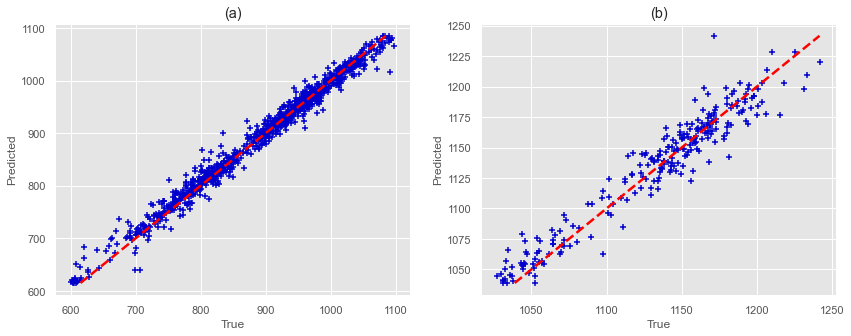

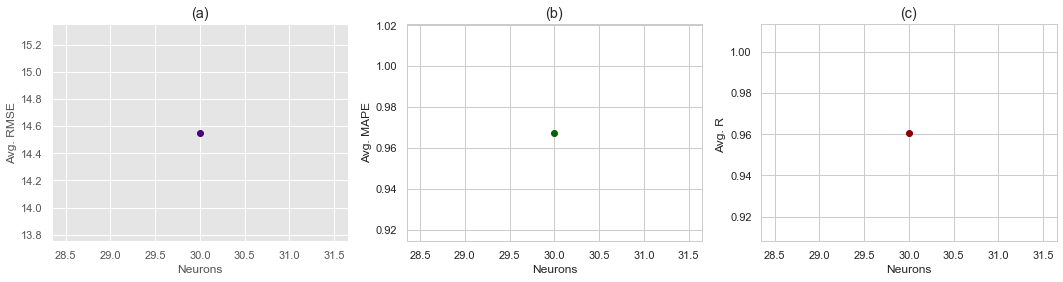

IndexError: index 1 is out of bounds for axis 0 with size 1

ValueError: view limit minimum -36920.700000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 1296x864 with 2 Axes>

In [24]:
# neurons = np.array([10, 30, 50, 100, 150,200])
neurons = np.array([30])

# best_hyper_parameters = [['Adam', 0.01, 16],# 10N model
#                       ['Adagrad', 0.01, 8], # 30N model
#                       ['Adagrad', 0.01, 4], # 50N model
#                       ['Adagrad', 0.01, 16], # 1000N model
#                       ['Adagrad', 0.01, 16], # 150N model
#                       ['Adagrad', 0.001, 4] # 200N model
#                    ]

# best_hyper_parameters = [['Adam', 0.01, 16],# 10N model
#                       ['Adam', 0.01, 16], # 30N model
#                       ['Adam', 0.001, 8], # 50N model
#                       ['Adam', 0.001, 16], # 1000N model
#                       ['Adam', 0.001, 16], # 150N model
#                       ['Adam', 0.001, 16] # 200N model
#                    ]

best_hyper_parameters = [['Adam', 0.01, 16], # 30N model
                         ]


sl_model_output = LSTM_model(neurons, best_hyper_parameters, data, time_step = 5, test_split = 0.2,
                          epochs = 50, num_replicates = 10)

create_visualization(sl_model_output)

DatetimeIndex(['2016-12-23', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2017-01-02', '2017-01-03', '2017-01-11',
               '2017-01-13', '2017-01-16',
               ...
               '2022-12-19', '2022-12-20', '2022-12-21', '2022-12-22',
               '2022-12-23', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', name='Tanggal', length=1241, freq=None)

### **Case II: Executing Multi-Layer Models**

In [ ]:
hidden_layers = [[10, 5], [20, 10], [50, 20], [100, 50], [150, 100], [100, 50, 20]]

best_hyper_parameters_multilayers  = [['Adagrad', 0.1, 4],#10-5N model
                                     ['Adagrad', 0.01, 16],#20-10N model
                                    ['Adagrad', 0.01, 16], #50-20N model
                                   ['Adagrad', 0.01, 16], #100-50N model
                                   ['Adagrad', 0.01, 16], #150-100N model
                                   ['Adagrad', 0.001, 8] #100-50-20N model
                                      ]

ml_model_output = run_multi_layer_LSTM_Model(hidden_layers, best_hyper_parameters_multilayers, data, time_step = 5, test_split = 0.2, epochs = 100,  num_replicates = 30) 

multi_layers_all_scores_boxplots(ml_model_output)




### **Case III: Performing Statistical Analysis**

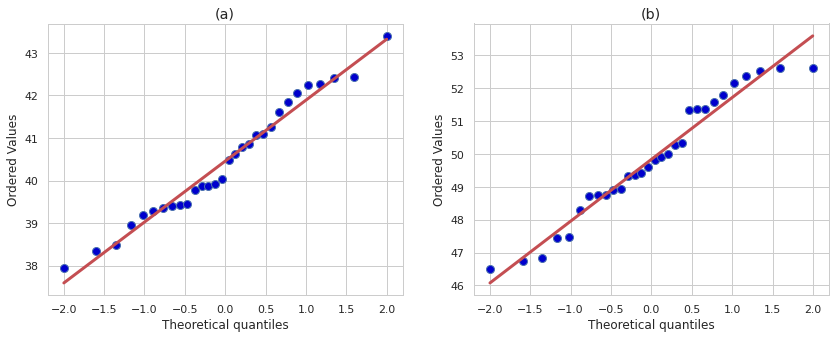

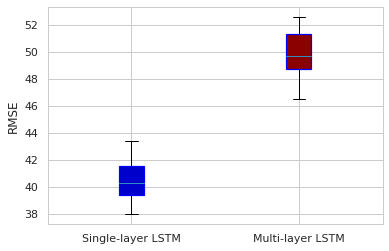

Performaing Normality Tests

Data1: 
NormaltestResult(statistic=1.4905288066235225, pvalue=0.4746087952114656)
Data 2:
NormaltestResult(statistic=2.1222308489898967, pvalue=0.3460695804779618)

Tests of Equality of Variances
F_statistic: 0.5751259056258581 F_pvalue: 0.9288785434286714
Levene_statistic: 1.9685925804783602 Levene_pvalue: 0.16592816550823955
Bartlett_statistic: 2.153597251460697 Bartlett_pvalue: 0.14223629186622289

Two-sample ttest
Ttest_indResult(statistic=-22.238765455511963, pvalue=7.084799222677942e-29)


In [ ]:
sl_index = 4 # index for the best single layers model(0: 10N,1:30N,2:50N,3:100N,4:150N,5:200N)

ml_index = 4  # index for the best multilayer models

sl_all_rmse = read_df_from_file(output_dir_path+'sl-lstm-all-rmse.csv')
ml_all_rmse = read_df_from_file(output_dir_path+'ml-lstm-all-rmse.csv')

data1 = sl_all_rmse.iloc[sl_index,1:]
data2 = ml_all_rmse.iloc[ml_index,1:]

perform_statistical_analysis(data1, data2)
